# ALS Project

## Functional scale analysis

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn

In [2]:
from scipy.stats import linregress
from collections import defaultdict

In [3]:
from eda_functions import dups
%matplotlib inline

### Functions

In [4]:
def linreg_scalers(df, subject_col, y_col, x_col, y_label):
    '''
    creates linear regression slopes, intercepts for every subject in a df.
    input:
        df = df
        subject_col = name of subject id column
        y_col = name of first y data column
        x_col = name of column with x values
        y_label = name of y feature (for table output)
    output:
        regression outputs in dataframe
    '''
    slopes = defaultdict()
    
    # list of every subject in table 
    subjects_list = list(np.unique(df[subject_col]))
    
    # for each subject
    for subj in subjects_list:
        data = df.loc[ df[subject_col]==subj].copy()
        y=data[y_col]
        x=data[x_col]

        # if only one record then skip
        if len(data)==1:
            continue
        else: # if missing values in x or y then skip
            if ~(y.isnull().any())  or (x.isnull().any()):
                y=np.array(y)
                x=np.array(x)
                # linregress is part of scipy.stats. 
                slope, intercept, r_value, p_value, std_err = linregress(x, y)
                slopes[subj] = (y_label, slope, intercept)

    # format as dataframe
    full_result = pd.DataFrame(slopes).transpose().reset_index()
    
    # relabel columns
    s_label = "slope_" + y_label 
    i_label = "intercept_" + y_label
    full_result.rename(index=str, columns={"index": "subject_id", 
                                      0: "test" ,1: s_label, 
                                      2: i_label }, inplace=True)
    
    # make small table
    mini_table = slope_mini_table(full_result.copy(), i_label)
    
    # return table
    return full_result, mini_table

In [5]:
def slope_mini_table(df, i_label):
    df.drop(['test', i_label], axis=1, inplace=True)
    df.dropna(axis=0, inplace=True)
    df.reset_index(drop=True, inplace=True)
    return df

In [6]:
def plot_question_long(df, y_col, x_col, subject_list):
    '''
    plot multiple lines on one plot
    input:
        df = df
        y_col = name of feature to plot
        x_col = name of time variable (usually) to plot
        subject_list = list of subject to inlude in plot
    '''
    plt.figure(figsize=(12,6))
    for subject in subject_list:
        this_df = df[ df['subject_id']==subject]
        plt.plot(this_df[x_col], this_df[y_col])
    #plt.axhline(100)
    plt.title("Question: {}".format(y_col))
    plt.ylabel(y_col)
    plt.xlabel(x_col)
    #plt.ylim(2,5)

In [7]:
def plot_line_over_actuals(df_points, df_slope, subject_col, y_col_points, y_col_slope, y_col_inter, x_col, y_label):
    subject_list = df_slope[subject_col].unique()
    df_slope.dropna(inplace=True)
    df_slope.reset_index(inplace=True)
    for subj in subject_list:
        points = df_points[ df_points[subject_col]==subj]
        line = df_slope[ df_slope[subject_col]==subj]
        points_data = np.all(~np.isnan(points[y_col].values))
        if points_data and line.shape[0]!=0:
            plt.figure(figsize=(8,4))
            plt.plot(points[x_col].values, points[y_col_points].values, label="actual")
            plt.plot(points[x_col].values,
                     line[y_col_inter].values + line[y_col_slope].values * points[x_col].values, 
                     '-', label="predicted") 
            plt.title("{} : {}".format(subj, y_label))
            plt.ylabel(y_label)
            plt.xlabel(x_col)
            #plt.ylim(8,56)
            plt.show()

## Load Data

In [8]:
scale = pd.read_csv("data/alsfrs.csv")
print(scale.shape)
scale.head()

(60775, 20)


,subject_id,Q1_Speech,Q2_Salivation,Q3_Swallowing,Q4_Handwriting,Q5a_Cutting_without_Gastrostomy,Q5b_Cutting_with_Gastrostomy,Q6_Dressing_and_Hygiene,Q7_Turning_in_Bed,Q8_Walking,Q9_Climbing_Stairs,Q10_Respiratory,ALSFRS_Delta,ALSFRS_Total,ALSFRS_R_Total,R_1_Dyspnea,R_2_Orthopnea,R_3_Respiratory_Insufficiency,Mode_of_Administration,ALSFRS_Responded_By
0,329,4.0,3.0,4.0,3.0,2.0,NaN,3.0,2.0,2.0,1.0,3.0,0.0,27.0,NaN,NaN,NaN,NaN,NaN,NaN
1,329,4.0,3.0,4.0,3.0,1.5,NaN,3.0,2.0,2.0,1.0,3.0,8.0,26.5,NaN,NaN,NaN,NaN,NaN,NaN
2,329,4.0,3.0,4.0,3.0,1.0,NaN,3.0,2.0,2.0,1.0,3.0,16.0,26.0,NaN,NaN,NaN,NaN,NaN,NaN
3,329,4.0,3.0,4.0,3.0,3.0,NaN,3.0,3.0,2.0,1.0,4.0,42.0,30.0,NaN,NaN,NaN,NaN,NaN,NaN
4,329,4.0,3.0,4.0,3.0,2.0,NaN,3.0,4.0,2.0,2.0,3.0,72.0,30.0,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
# rename _delta to study day
scale['study_day'] = scale['ALSFRS_Delta']

In [10]:
# remove 'Mode_of_Administration', 'ALSFRS_Responded_By' column - empty
scale.drop(['Mode_of_Administration','ALSFRS_Responded_By', 'ALSFRS_Delta'],
              axis=1, inplace=True)
scale.head()

,subject_id,Q1_Speech,Q2_Salivation,Q3_Swallowing,Q4_Handwriting,Q5a_Cutting_without_Gastrostomy,Q5b_Cutting_with_Gastrostomy,Q6_Dressing_and_Hygiene,Q7_Turning_in_Bed,Q8_Walking,Q9_Climbing_Stairs,Q10_Respiratory,ALSFRS_Total,ALSFRS_R_Total,R_1_Dyspnea,R_2_Orthopnea,R_3_Respiratory_Insufficiency,study_day
0,329,4.0,3.0,4.0,3.0,2.0,NaN,3.0,2.0,2.0,1.0,3.0,27.0,NaN,NaN,NaN,NaN,0.0
1,329,4.0,3.0,4.0,3.0,1.5,NaN,3.0,2.0,2.0,1.0,3.0,26.5,NaN,NaN,NaN,NaN,8.0
2,329,4.0,3.0,4.0,3.0,1.0,NaN,3.0,2.0,2.0,1.0,3.0,26.0,NaN,NaN,NaN,NaN,16.0
3,329,4.0,3.0,4.0,3.0,3.0,NaN,3.0,3.0,2.0,1.0,4.0,30.0,NaN,NaN,NaN,NaN,42.0
4,329,4.0,3.0,4.0,3.0,2.0,NaN,3.0,4.0,2.0,2.0,3.0,30.0,NaN,NaN,NaN,NaN,72.0


In [11]:
# max ALSFRS_Total score
print("n ALSFRS_Total: {}".format(sum(scale['ALSFRS_Total'].notnull())))
print("max ALSFRS_Total: {}".format(scale['ALSFRS_Total'].max()))
print("min ALSFRS_Total: {}".format(scale['ALSFRS_Total'].min()))
print()
print("n ALSFRS_R_Total: {}".format(sum(scale['ALSFRS_R_Total'].notnull())))
print("max ALSFRS_R_Total: {}".format(scale['ALSFRS_R_Total'].max()))
print("min ALSFRS_R_Total: {}".format(scale['ALSFRS_R_Total'].min()))

n ALSFRS_Total: 36385
max ALSFRS_Total: 44.0
min ALSFRS_Total: 0.0

n ALSFRS_R_Total: 31498
max ALSFRS_R_Total: 48.0
min ALSFRS_R_Total: 0.0


/Applications/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Applications/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


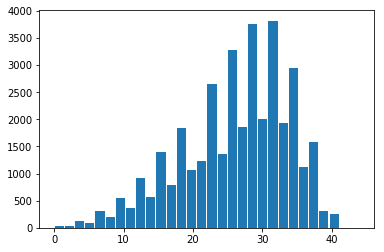

In [12]:
# theoretically the max score is 40! What are there values above this?
plt.hist(scale['ALSFRS_Total'], bins=30, rwidth=0.9)
plt.show()

In [13]:
# there is one record which is wrong.
scale[ scale['ALSFRS_Total']>40]

,subject_id,Q1_Speech,Q2_Salivation,Q3_Swallowing,Q4_Handwriting,Q5a_Cutting_without_Gastrostomy,Q5b_Cutting_with_Gastrostomy,Q6_Dressing_and_Hygiene,Q7_Turning_in_Bed,Q8_Walking,Q9_Climbing_Stairs,Q10_Respiratory,ALSFRS_Total,ALSFRS_R_Total,R_1_Dyspnea,R_2_Orthopnea,R_3_Respiratory_Insufficiency,study_day
26358,438564,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,44.0,NaN,NaN,NaN,NaN,302.0


In [14]:
# replace the 44 value with 40
scale['ALSFRS_Total'].replace(44, 40, inplace=True)
# fixed. nothing above 40 here. 
scale[ scale['ALSFRS_Total']>40]

,subject_id,Q1_Speech,Q2_Salivation,Q3_Swallowing,Q4_Handwriting,Q5a_Cutting_without_Gastrostomy,Q5b_Cutting_with_Gastrostomy,Q6_Dressing_and_Hygiene,Q7_Turning_in_Bed,Q8_Walking,Q9_Climbing_Stairs,Q10_Respiratory,ALSFRS_Total,ALSFRS_R_Total,R_1_Dyspnea,R_2_Orthopnea,R_3_Respiratory_Insufficiency,study_day


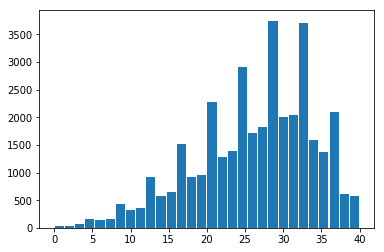

In [15]:
# corrected
plt.hist(scale['ALSFRS_Total'], bins=30, rwidth=0.9)
plt.show()

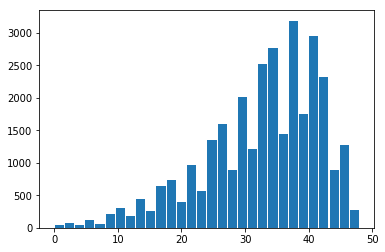

In [16]:
# anything wrong with revised scale?
plt.hist(scale['ALSFRS_R_Total'], bins=30, rwidth=0.9)
plt.show()

In [17]:
# number questionaires per subject
grp_sub_scale = scale.groupby('subject_id')
n_qs = grp_sub_scale['subject_id'].count()
print(n_qs.head())

subject_id
329    12
348    15
533     6
586     1
649    12
Name: subject_id, dtype: int64


In [18]:
print(scale.shape)
scale.head()

(60775, 18)


,subject_id,Q1_Speech,Q2_Salivation,Q3_Swallowing,Q4_Handwriting,Q5a_Cutting_without_Gastrostomy,Q5b_Cutting_with_Gastrostomy,Q6_Dressing_and_Hygiene,Q7_Turning_in_Bed,Q8_Walking,Q9_Climbing_Stairs,Q10_Respiratory,ALSFRS_Total,ALSFRS_R_Total,R_1_Dyspnea,R_2_Orthopnea,R_3_Respiratory_Insufficiency,study_day
0,329,4.0,3.0,4.0,3.0,2.0,NaN,3.0,2.0,2.0,1.0,3.0,27.0,NaN,NaN,NaN,NaN,0.0
1,329,4.0,3.0,4.0,3.0,1.5,NaN,3.0,2.0,2.0,1.0,3.0,26.5,NaN,NaN,NaN,NaN,8.0
2,329,4.0,3.0,4.0,3.0,1.0,NaN,3.0,2.0,2.0,1.0,3.0,26.0,NaN,NaN,NaN,NaN,16.0
3,329,4.0,3.0,4.0,3.0,3.0,NaN,3.0,3.0,2.0,1.0,4.0,30.0,NaN,NaN,NaN,NaN,42.0
4,329,4.0,3.0,4.0,3.0,2.0,NaN,3.0,4.0,2.0,2.0,3.0,30.0,NaN,NaN,NaN,NaN,72.0


## Create anchor point for each subject at disease onset date

In [17]:
# merge table with onset data
# load onset dates
onset=pd.read_csv("clean_data/onset_date.csv")

In [18]:
print(onset.shape)
onset.head()

(6879, 3)


,subject_id,Onset_Delta,delta_onset_diag
0,329,-1706.0,638.0
1,348,-501.0,199.0
2,533,-1023.0,979.0
3,586,-715.0,208.0
4,649,-341.0,NaN


In [19]:
so = scale.merge(onset, how='left', on='subject_id')

In [20]:
print(so.shape)
so.head()

(60775, 20)


,subject_id,Q1_Speech,Q2_Salivation,Q3_Swallowing,Q4_Handwriting,Q5a_Cutting_without_Gastrostomy,Q5b_Cutting_with_Gastrostomy,Q6_Dressing_and_Hygiene,Q7_Turning_in_Bed,Q8_Walking,Q9_Climbing_Stairs,Q10_Respiratory,ALSFRS_Total,ALSFRS_R_Total,R_1_Dyspnea,R_2_Orthopnea,R_3_Respiratory_Insufficiency,study_day,Onset_Delta,delta_onset_diag
0,329,4.0,3.0,4.0,3.0,2.0,NaN,3.0,2.0,2.0,1.0,3.0,27.0,NaN,NaN,NaN,NaN,0.0,-1706.0,638.0
1,329,4.0,3.0,4.0,3.0,1.5,NaN,3.0,2.0,2.0,1.0,3.0,26.5,NaN,NaN,NaN,NaN,8.0,-1706.0,638.0
2,329,4.0,3.0,4.0,3.0,1.0,NaN,3.0,2.0,2.0,1.0,3.0,26.0,NaN,NaN,NaN,NaN,16.0,-1706.0,638.0
3,329,4.0,3.0,4.0,3.0,3.0,NaN,3.0,3.0,2.0,1.0,4.0,30.0,NaN,NaN,NaN,NaN,42.0,-1706.0,638.0
4,329,4.0,3.0,4.0,3.0,2.0,NaN,3.0,4.0,2.0,2.0,3.0,30.0,NaN,NaN,NaN,NaN,72.0,-1706.0,638.0


In [21]:
so['day_since_onset']= np.abs(so['Onset_Delta']) + so['study_day']
print(so.shape)
so.head()

(60775, 21)


,subject_id,Q1_Speech,Q2_Salivation,Q3_Swallowing,Q4_Handwriting,Q5a_Cutting_without_Gastrostomy,Q5b_Cutting_with_Gastrostomy,Q6_Dressing_and_Hygiene,Q7_Turning_in_Bed,Q8_Walking,...,Q10_Respiratory,ALSFRS_Total,ALSFRS_R_Total,R_1_Dyspnea,R_2_Orthopnea,R_3_Respiratory_Insufficiency,study_day,Onset_Delta,delta_onset_diag,day_since_onset
0,329,4.0,3.0,4.0,3.0,2.0,NaN,3.0,2.0,2.0,...,3.0,27.0,NaN,NaN,NaN,NaN,0.0,-1706.0,638.0,1706.0
1,329,4.0,3.0,4.0,3.0,1.5,NaN,3.0,2.0,2.0,...,3.0,26.5,NaN,NaN,NaN,NaN,8.0,-1706.0,638.0,1714.0
2,329,4.0,3.0,4.0,3.0,1.0,NaN,3.0,2.0,2.0,...,3.0,26.0,NaN,NaN,NaN,NaN,16.0,-1706.0,638.0,1722.0
3,329,4.0,3.0,4.0,3.0,3.0,NaN,3.0,3.0,2.0,...,4.0,30.0,NaN,NaN,NaN,NaN,42.0,-1706.0,638.0,1748.0
4,329,4.0,3.0,4.0,3.0,2.0,NaN,3.0,4.0,2.0,...,3.0,30.0,NaN,NaN,NaN,NaN,72.0,-1706.0,638.0,1778.0


## Get max date from functional assessment

In [22]:
function_max_date = so.groupby('subject_id').max()
function_max_date.reset_index(inplace=True)
function_max_date['max_func_date_onset'] = function_max_date['day_since_onset']
function_max_date=function_max_date[['subject_id', 'max_func_date_onset']]
function_max_date.head()

,subject_id,max_func_date_onset
0,329,1980.0
1,348,902.0
2,533,1401.0
3,586,718.0
4,649,898.0


In [77]:
# save to csv
filename = 'clean_data/max_func_date.csv'
function_max_date.to_csv(filename, index=False)

if ALSFRS_R_Total is empty then leave these fields empty: R_1_Dyspnea, R_2_Orthopnea, R_3_Respiratory_Insufficiency, Q5b_Cutting_with_Gastrostomy

In [23]:
# so groupby subjects
g_so = so.groupby('subject_id').count()
print(g_so.shape)
g_so.head()

(6844, 20)


,Q1_Speech,Q2_Salivation,Q3_Swallowing,Q4_Handwriting,Q5a_Cutting_without_Gastrostomy,Q5b_Cutting_with_Gastrostomy,Q6_Dressing_and_Hygiene,Q7_Turning_in_Bed,Q8_Walking,Q9_Climbing_Stairs,Q10_Respiratory,ALSFRS_Total,ALSFRS_R_Total,R_1_Dyspnea,R_2_Orthopnea,R_3_Respiratory_Insufficiency,study_day,Onset_Delta,delta_onset_diag,day_since_onset
subject_id,,,,,,,,,,,,,,,,,,,,
329,12,12,12,12,12,0,12,12,12,12,12,12,0,0,0,0,12,12,12,12
348,15,15,15,15,15,0,15,15,15,15,0,0,15,15,15,15,15,15,15,15
533,6,6,6,6,4,2,6,6,6,6,6,6,6,6,6,6,6,6,6,6
586,1,1,1,1,1,0,1,1,1,1,0,0,1,1,1,1,1,1,1,1
649,12,12,12,12,10,2,12,12,12,12,12,12,0,0,0,0,12,12,0,12


In [25]:
# make all values = 4
g_so [ g_so != 4] = 4

# replace individual scores as needed.
g_so['ALSFRS_Total'].replace(4,40, inplace=True)
g_so['ALSFRS_R_Total'].replace(4,48, inplace=True)
g_so['day_since_onset'].replace(4,0, inplace=True)
g_so['Onset_Delta'].replace(4,0, inplace=True)
g_so['study_day'].replace(4,0, inplace=True)

# reset the index (groupby indexed changed)
g_so.reset_index(inplace=True)

print(g_so.shape)
g_so.head()

(6844, 21)


,subject_id,Q1_Speech,Q2_Salivation,Q3_Swallowing,Q4_Handwriting,Q5a_Cutting_without_Gastrostomy,Q5b_Cutting_with_Gastrostomy,Q6_Dressing_and_Hygiene,Q7_Turning_in_Bed,Q8_Walking,...,Q10_Respiratory,ALSFRS_Total,ALSFRS_R_Total,R_1_Dyspnea,R_2_Orthopnea,R_3_Respiratory_Insufficiency,study_day,Onset_Delta,delta_onset_diag,day_since_onset
0,329,4,4,4,4,4,4,4,4,4,...,4,40,48,4,4,4,0,0,4,0
1,348,4,4,4,4,4,4,4,4,4,...,4,40,48,4,4,4,0,0,4,0
2,533,4,4,4,4,4,4,4,4,4,...,4,40,48,4,4,4,0,0,4,0
3,586,4,4,4,4,4,4,4,4,4,...,4,40,48,4,4,4,0,0,4,0
4,649,4,4,4,4,4,4,4,4,4,...,4,40,48,4,4,4,0,0,4,0


In [26]:
# merge g_so with so
scale_onset = pd.concat([so, g_so])

In [27]:
scale_onset.sort_values(by=['subject_id', 'day_since_onset'], inplace=True)
scale_onset.reset_index(drop=True, inplace=True)
print(scale_onset.shape)
scale_onset.head()

(67619, 21)


,subject_id,Q1_Speech,Q2_Salivation,Q3_Swallowing,Q4_Handwriting,Q5a_Cutting_without_Gastrostomy,Q5b_Cutting_with_Gastrostomy,Q6_Dressing_and_Hygiene,Q7_Turning_in_Bed,Q8_Walking,...,Q10_Respiratory,ALSFRS_Total,ALSFRS_R_Total,R_1_Dyspnea,R_2_Orthopnea,R_3_Respiratory_Insufficiency,study_day,Onset_Delta,delta_onset_diag,day_since_onset
0,329,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,...,4.0,40.0,48.0,4.0,4.0,4.0,0.0,0.0,4.0,0.0
1,329,4.0,3.0,4.0,3.0,2.0,NaN,3.0,2.0,2.0,...,3.0,27.0,NaN,NaN,NaN,NaN,0.0,-1706.0,638.0,1706.0
2,329,4.0,3.0,4.0,3.0,1.5,NaN,3.0,2.0,2.0,...,3.0,26.5,NaN,NaN,NaN,NaN,8.0,-1706.0,638.0,1714.0
3,329,4.0,3.0,4.0,3.0,1.0,NaN,3.0,2.0,2.0,...,3.0,26.0,NaN,NaN,NaN,NaN,16.0,-1706.0,638.0,1722.0
4,329,4.0,3.0,4.0,3.0,3.0,NaN,3.0,3.0,2.0,...,4.0,30.0,NaN,NaN,NaN,NaN,42.0,-1706.0,638.0,1748.0


In [28]:
# get max day since onset for each subject
gr = scale_onset.groupby('subject_id').max

#### Get slope for every subject with at least 2 scale assessments

In [94]:
# for each subject, perform lin regress on values
# save slope and intercept to dictionary
subject_col='subject_id'
y_col1='ALSFRS_R_Total'
y_col2='ALSFRS_Total'
x_col='day_since_onset'

# the dataframe
df = scale_onset[['subject_id', 'ALSFRS_Total', 'ALSFRS_R_Total', 
                                'day_since_onset']].copy()

# list of every subject in table 
subjects_list = list(np.unique(df[subject_col]))

In [95]:
#def linreg_scalers(df, subjects_list, subject_col, y_col1, y_col2, x_col):
'''
saves linear regression slopes, intercepts for every subject in a df.
input:
    df = df
    subjects_list = list of unique subject names
    subject_col = name of subject id column
    y_col1 = name of first y data column
    y_col2 = name of second y data column
    x_col = name of column with x values 
output:
    regression outputs in dataframe
'''
slopes = defaultdict()
# for each subject
for subj in subjects_list:
    data = df.loc[ df[subject_col]==subj].copy()
    y1=data[y_col1]
    y2=data[y_col2]
    x=data[x_col]

    # if only one record then skip
    if len(data)==1:
        continue
    # if missing values in x or y then skip
    if ( (y1.isnull().any()) and (y2.isnull().any()) ) or (x.isnull().any()):
        continue
    if ~y1.isnull().any():
        y=np.array(y1)
        x=np.array(x)
        # linregress is part of scipy.stats. 
        slope, intercept, r_value, p_value, std_err = linregress(x, y)
        slopes[subj] = ('revised',slope,intercept)
    else:
        y=np.array(y2)
        x=np.array(x)
        slope, intercept, r_value, p_value, std_err = linregress(x, y)
        slopes[subj] = ('original', slope,intercept)

# return the dictionary as a formated dataframe
linreg = pd.DataFrame(slopes).transpose().reset_index()
linreg.rename(index=str, columns={"index": "subject_id", 0: "scale" ,1: "slope", 2: "intercept"}, 
          inplace=True)

In [96]:
print(linreg.shape)
linreg.head()
# note 377 missing subjects. presume only had one value??

(6537, 4)


,subject_id,scale,slope,intercept
0,329,original,-0.00709158,40.0843
1,348,revised,-0.0127195,46.4282
2,533,revised,-0.0109401,48.2314
3,586,revised,-0.0125348,48
4,649,original,-0.0204649,43.3664


In [97]:
# save to csv
filename = 'clean_data/scale_assess_slope.csv'
linreg.to_csv(filename, index=False)

## Find linear regression of each ONSET-Anchored question (not including total score)

In [29]:
# head 
print(scale_onset.shape)
scale_onset.head()

(67619, 21)


,subject_id,Q1_Speech,Q2_Salivation,Q3_Swallowing,Q4_Handwriting,Q5a_Cutting_without_Gastrostomy,Q5b_Cutting_with_Gastrostomy,Q6_Dressing_and_Hygiene,Q7_Turning_in_Bed,Q8_Walking,...,Q10_Respiratory,ALSFRS_Total,ALSFRS_R_Total,R_1_Dyspnea,R_2_Orthopnea,R_3_Respiratory_Insufficiency,study_day,Onset_Delta,delta_onset_diag,day_since_onset
0,329,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,...,4.0,40.0,48.0,4.0,4.0,4.0,0.0,0.0,4.0,0.0
1,329,4.0,3.0,4.0,3.0,2.0,NaN,3.0,2.0,2.0,...,3.0,27.0,NaN,NaN,NaN,NaN,0.0,-1706.0,638.0,1706.0
2,329,4.0,3.0,4.0,3.0,1.5,NaN,3.0,2.0,2.0,...,3.0,26.5,NaN,NaN,NaN,NaN,8.0,-1706.0,638.0,1714.0
3,329,4.0,3.0,4.0,3.0,1.0,NaN,3.0,2.0,2.0,...,3.0,26.0,NaN,NaN,NaN,NaN,16.0,-1706.0,638.0,1722.0
4,329,4.0,3.0,4.0,3.0,3.0,NaN,3.0,3.0,2.0,...,4.0,30.0,NaN,NaN,NaN,NaN,42.0,-1706.0,638.0,1748.0


In [30]:
scale_onset.columns

Index(['subject_id', 'Q1_Speech', 'Q2_Salivation', 'Q3_Swallowing',
       'Q4_Handwriting', 'Q5a_Cutting_without_Gastrostomy',
       'Q5b_Cutting_with_Gastrostomy', 'Q6_Dressing_and_Hygiene',
       'Q7_Turning_in_Bed', 'Q8_Walking', 'Q9_Climbing_Stairs',
       'Q10_Respiratory', 'ALSFRS_Total', 'ALSFRS_R_Total', 'R_1_Dyspnea',
       'R_2_Orthopnea', 'R_3_Respiratory_Insufficiency', 'study_day',
       'Onset_Delta', 'delta_onset_diag', 'day_since_onset'],
      dtype='object')

In [48]:
# this code block only an example of the first question. dont't need to run everytime.
q1 = scale_onset[['subject_id', 'day_since_onset','Q1_Speech']].copy()
q1.dropna(inplace=True)
gr1= q1.groupby('subject_id').count()
gr1.head()

,day_since_onset,Q1_Speech
subject_id,,
329,13,13
348,16,16
533,7,7
586,2,2
649,13,13


In [176]:
# perform linear regression  on each question
# the dataframe
df = scale_onset.copy()

# the columns
subject_col='subject_id'
y_col='R_3_Respiratory_Insufficiency'
x_col='day_since_onset'
y_label = y_col

# plot the question values
subject_list = df[subject_col].unique()[0:50]
plot_question_long(df, y_col, x_col, subject_list)

# run the linreg function
qR_3_full, qR_3_mini = linreg_scalers(df, subject_col, y_col, x_col, y_label)

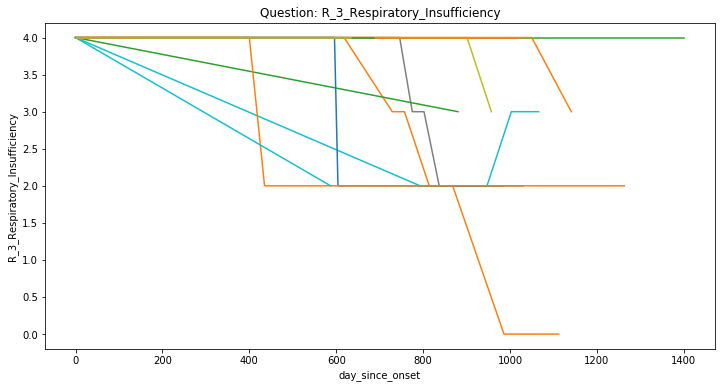

In [179]:
print(qR_3_full.shape)
qR_3_full.head()

(3558, 4)


,subject_id,test,slope_R_3_Respiratory_Insufficiency,intercept_R_3_Respiratory_Insufficiency
0,348,R_3_Respiratory_Insufficiency,0,4
1,533,R_3_Respiratory_Insufficiency,0,4
2,586,R_3_Respiratory_Insufficiency,0,4
3,902,R_3_Respiratory_Insufficiency,0,4
4,1064,R_3_Respiratory_Insufficiency,-0.00293077,5.27197


In [180]:
print(qR_3_mini.shape)
qR_3_mini.head()

(3260, 2)


,subject_id,slope_R_3_Respiratory_Insufficiency
0,348,0
1,533,0
2,586,0
3,902,0
4,1064,-0.00293077


In [182]:
# save to csv
filename = 'clean_data/qR_3_slope.csv'
qR_3_mini.to_csv(filename, index=False)

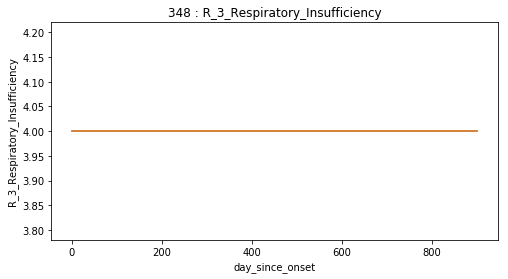

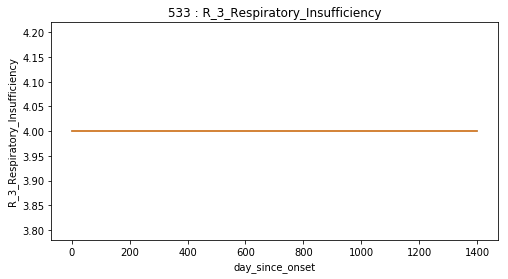

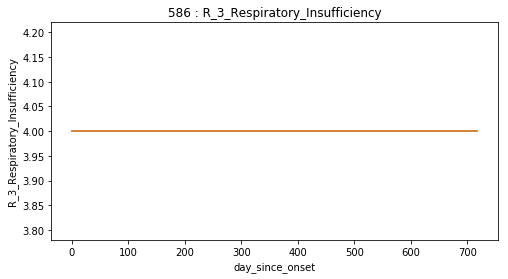

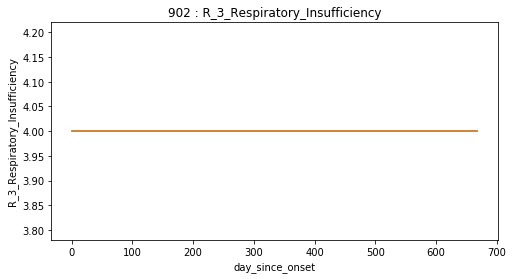

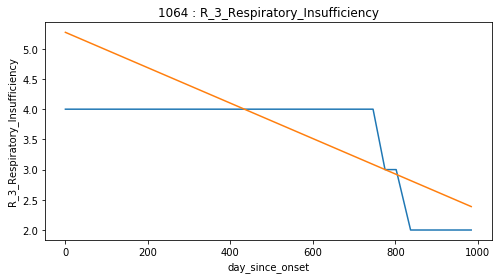

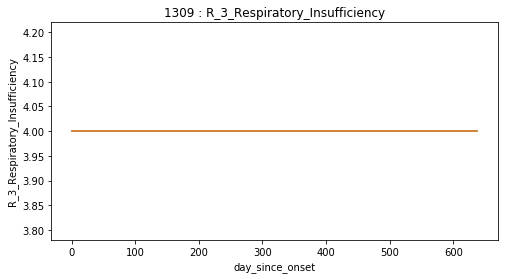

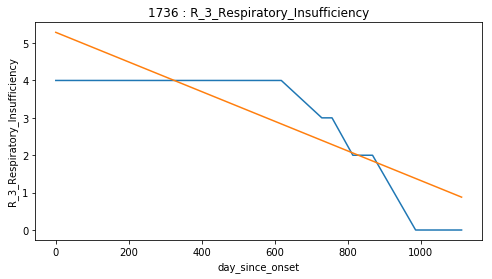

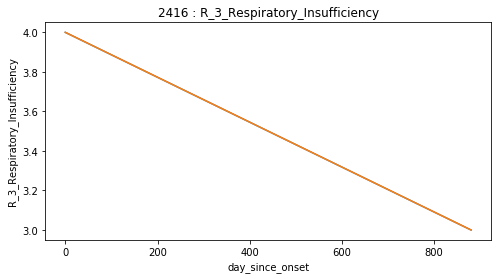

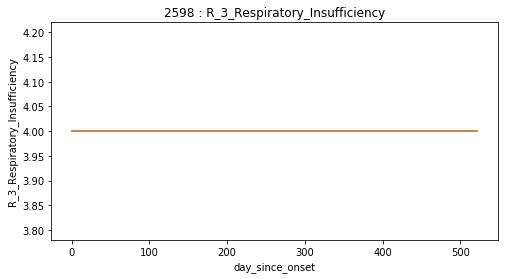

In [181]:
# plot the values over actuals
# plot a few subject's points with linear regression line
# note: only takes one assessment

# the dataframe
#plot first few subjects data 
limit_subjects = scale_onset['subject_id'].unique()[0:20]
df_points = scale_onset[ scale_onset['subject_id'].isin(limit_subjects)].copy()
df_slope = qR_3_full[ qR_3_full['subject_id'].isin(limit_subjects)].copy()

# the columns
subject_col = subject_col
x_col = x_col
y_col_points = y_col
y_col_slope = 'slope_'+y_col
y_col_inter = 'intercept_'+y_col
y_label = y_label

plot_line_over_actuals(df_points, df_slope, subject_col, y_col_points, 
                       y_col_slope, y_col_inter, x_col, y_label)

## Find linear regression of each NON-Anchored question

In [20]:
# head 
print(scale.shape)
scale.head(10)

(60775, 18)


,subject_id,Q1_Speech,Q2_Salivation,Q3_Swallowing,Q4_Handwriting,Q5a_Cutting_without_Gastrostomy,Q5b_Cutting_with_Gastrostomy,Q6_Dressing_and_Hygiene,Q7_Turning_in_Bed,Q8_Walking,Q9_Climbing_Stairs,Q10_Respiratory,ALSFRS_Total,ALSFRS_R_Total,R_1_Dyspnea,R_2_Orthopnea,R_3_Respiratory_Insufficiency,study_day
0,329,4.0,3.0,4.0,3.0,2.0,NaN,3.0,2.0,2.0,1.0,3.0,27.0,NaN,NaN,NaN,NaN,0.0
1,329,4.0,3.0,4.0,3.0,1.5,NaN,3.0,2.0,2.0,1.0,3.0,26.5,NaN,NaN,NaN,NaN,8.0
2,329,4.0,3.0,4.0,3.0,1.0,NaN,3.0,2.0,2.0,1.0,3.0,26.0,NaN,NaN,NaN,NaN,16.0
3,329,4.0,3.0,4.0,3.0,3.0,NaN,3.0,3.0,2.0,1.0,4.0,30.0,NaN,NaN,NaN,NaN,42.0
4,329,4.0,3.0,4.0,3.0,2.0,NaN,3.0,4.0,2.0,2.0,3.0,30.0,NaN,NaN,NaN,NaN,72.0
5,329,3.0,3.0,4.0,3.0,4.0,NaN,3.0,4.0,2.0,2.0,4.0,32.0,NaN,NaN,NaN,NaN,106.0
6,329,4.0,3.0,3.0,3.0,1.0,NaN,3.0,3.0,2.0,1.0,4.0,27.0,NaN,NaN,NaN,NaN,135.0
7,329,4.0,4.0,4.0,1.0,1.0,NaN,1.0,2.0,2.0,1.0,1.0,21.0,NaN,NaN,NaN,NaN,168.0
8,329,4.0,2.0,4.0,3.0,1.0,NaN,3.0,2.0,2.0,1.0,3.0,25.0,NaN,NaN,NaN,NaN,189.0
9,329,4.0,4.0,4.0,3.0,3.0,NaN,3.0,3.0,2.0,1.0,3.0,30.0,NaN,NaN,NaN,NaN,212.0


In [29]:
# how many assessments at each study visit?
first_99_days = scale[ scale['study_day']<=99]
print(first_99_days.shape)
first_99_days.head()

(23233, 18)


,subject_id,Q1_Speech,Q2_Salivation,Q3_Swallowing,Q4_Handwriting,Q5a_Cutting_without_Gastrostomy,Q5b_Cutting_with_Gastrostomy,Q6_Dressing_and_Hygiene,Q7_Turning_in_Bed,Q8_Walking,Q9_Climbing_Stairs,Q10_Respiratory,ALSFRS_Total,ALSFRS_R_Total,R_1_Dyspnea,R_2_Orthopnea,R_3_Respiratory_Insufficiency,study_day
0,329,4.0,3.0,4.0,3.0,2.0,NaN,3.0,2.0,2.0,1.0,3.0,27.0,NaN,NaN,NaN,NaN,0.0
1,329,4.0,3.0,4.0,3.0,1.5,NaN,3.0,2.0,2.0,1.0,3.0,26.5,NaN,NaN,NaN,NaN,8.0
2,329,4.0,3.0,4.0,3.0,1.0,NaN,3.0,2.0,2.0,1.0,3.0,26.0,NaN,NaN,NaN,NaN,16.0
3,329,4.0,3.0,4.0,3.0,3.0,NaN,3.0,3.0,2.0,1.0,4.0,30.0,NaN,NaN,NaN,NaN,42.0
4,329,4.0,3.0,4.0,3.0,2.0,NaN,3.0,4.0,2.0,2.0,3.0,30.0,NaN,NaN,NaN,NaN,72.0


In [30]:
first_99_days.columns

Index(['subject_id', 'Q1_Speech', 'Q2_Salivation', 'Q3_Swallowing',
       'Q4_Handwriting', 'Q5a_Cutting_without_Gastrostomy',
       'Q5b_Cutting_with_Gastrostomy', 'Q6_Dressing_and_Hygiene',
       'Q7_Turning_in_Bed', 'Q8_Walking', 'Q9_Climbing_Stairs',
       'Q10_Respiratory', 'ALSFRS_Total', 'ALSFRS_R_Total', 'R_1_Dyspnea',
       'R_2_Orthopnea', 'R_3_Respiratory_Insufficiency', 'study_day'],
      dtype='object')

In [48]:
# this code block only an example of the first question. dont't need to run everytime.
q1 = scale_onset[['subject_id', 'day_since_onset','Q1_Speech']].copy()
q1.dropna(inplace=True)
gr1= q1.groupby('subject_id').count()
gr1.head()

,day_since_onset,Q1_Speech
subject_id,,
329,13,13
348,16,16
533,7,7
586,2,2
649,13,13


In [31]:
# perform linear regression  on each question
# the dataframe
df = first_99_days.copy()

# the columns
subject_col='subject_id'
y_col='Q1_Speech'
x_col='study_day'
y_label = y_col

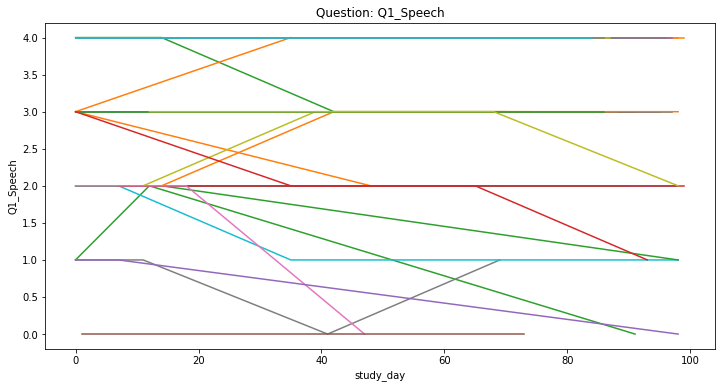

In [32]:
# plot the question values
subject_list = df[subject_col].unique()[0:50]
plot_question_long(df, y_col, x_col, subject_list)

In [178]:
# run the linreg function
qR_3_full, qR_3_mini = linreg_scalers(df, subject_col, y_col, x_col, y_label)

In [179]:
print(qR_3_full.shape)
qR_3_full.head()

(3558, 4)


,subject_id,test,slope_R_3_Respiratory_Insufficiency,intercept_R_3_Respiratory_Insufficiency
0,348,R_3_Respiratory_Insufficiency,0,4
1,533,R_3_Respiratory_Insufficiency,0,4
2,586,R_3_Respiratory_Insufficiency,0,4
3,902,R_3_Respiratory_Insufficiency,0,4
4,1064,R_3_Respiratory_Insufficiency,-0.00293077,5.27197


In [180]:
print(qR_3_mini.shape)
qR_3_mini.head()

(3260, 2)


,subject_id,slope_R_3_Respiratory_Insufficiency
0,348,0
1,533,0
2,586,0
3,902,0
4,1064,-0.00293077


In [182]:
# save to csv
filename = 'clean_data/qR_3_slope.csv'
qR_3_mini.to_csv(filename, index=False)

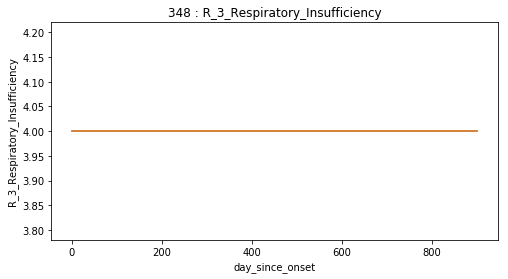

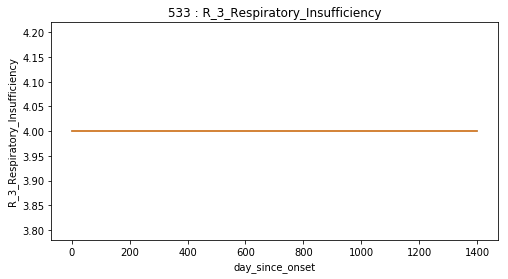

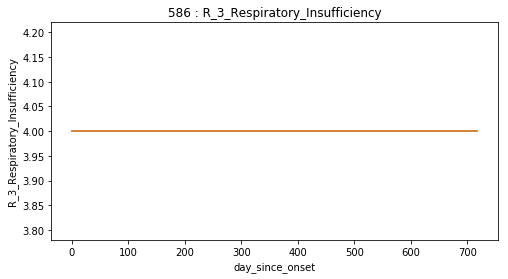

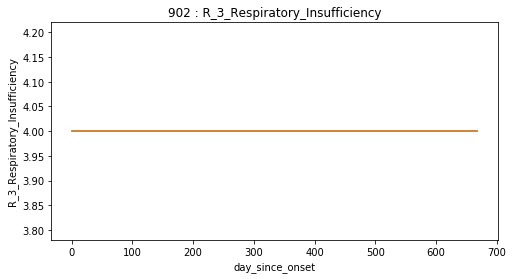

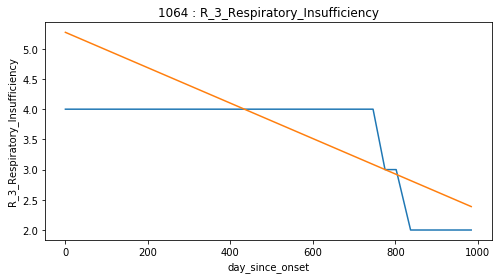

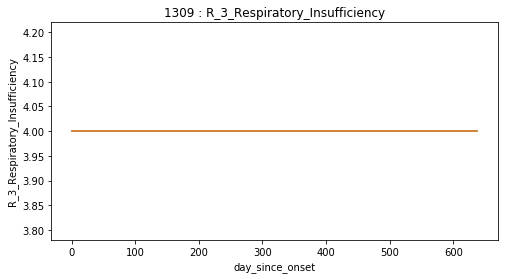

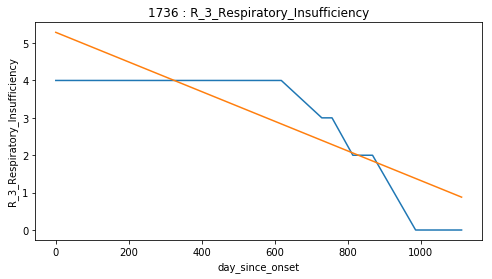

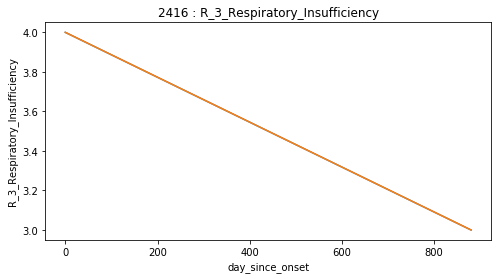

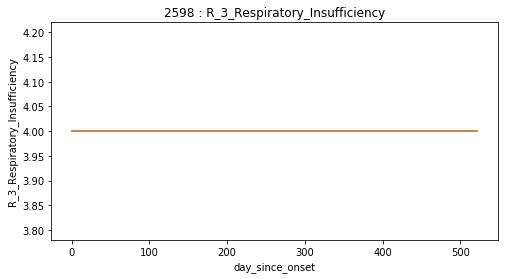

In [181]:
# plot the values over actuals
# plot a few subject's points with linear regression line
# note: only takes one assessment

# the dataframe
#plot first few subjects data 
limit_subjects = scale_onset['subject_id'].unique()[0:20]
df_points = scale_onset[ scale_onset['subject_id'].isin(limit_subjects)].copy()
df_slope = qR_3_full[ qR_3_full['subject_id'].isin(limit_subjects)].copy()

# the columns
subject_col = subject_col
x_col = x_col
y_col_points = y_col
y_col_slope = 'slope_'+y_col
y_col_inter = 'intercept_'+y_col
y_label = y_label

plot_line_over_actuals(df_points, df_slope, subject_col, y_col_points, 
                       y_col_slope, y_col_inter, x_col, y_label)

## Average change in score
below this line is work on the average change - not to be used.

In [317]:
# add death date
death=pd.read_csv("clean_data/death_date.csv")
print(death.shape)
death.head()

(8408, 2)


,subject_id,death_day_since_onset
0,89,NaN
1,411,NaN
2,708,1320.0
3,902,NaN
4,1312,NaN


In [318]:
scale_do = scale_onset.merge(death, how="left", on='subject_id')

In [319]:
print(scale_do.shape)
scale_do.head(14)

(67619, 23)


,subject_id,Q1_Speech,Q2_Salivation,Q3_Swallowing,Q4_Handwriting,Q5a_Cutting_without_Gastrostomy,Q5b_Cutting_with_Gastrostomy,Q6_Dressing_and_Hygiene,Q7_Turning_in_Bed,Q8_Walking,...,ALSFRS_R_Total,R_1_Dyspnea,R_2_Orthopnea,R_3_Respiratory_Insufficiency,study_day,Onset_Delta,Diagnosis_Delta,delta_onset_diag,day_since_onset,death_day_since_onset
0,329,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,...,48.0,4.0,4.0,4.0,0.0,0.0,0.0,4.0,0.0,NaN
1,329,4.0,3.0,4.0,3.0,2.0,NaN,3.0,2.0,2.0,...,NaN,NaN,NaN,NaN,0.0,-1706.0,-1068.0,638.0,1706.0,NaN
2,329,4.0,3.0,4.0,3.0,1.5,NaN,3.0,2.0,2.0,...,NaN,NaN,NaN,NaN,8.0,-1706.0,-1068.0,638.0,1714.0,NaN
3,329,4.0,3.0,4.0,3.0,1.0,NaN,3.0,2.0,2.0,...,NaN,NaN,NaN,NaN,16.0,-1706.0,-1068.0,638.0,1722.0,NaN
4,329,4.0,3.0,4.0,3.0,3.0,NaN,3.0,3.0,2.0,...,NaN,NaN,NaN,NaN,42.0,-1706.0,-1068.0,638.0,1748.0,NaN
5,329,4.0,3.0,4.0,3.0,2.0,NaN,3.0,4.0,2.0,...,NaN,NaN,NaN,NaN,72.0,-1706.0,-1068.0,638.0,1778.0,NaN
6,329,3.0,3.0,4.0,3.0,4.0,NaN,3.0,4.0,2.0,...,NaN,NaN,NaN,NaN,106.0,-1706.0,-1068.0,638.0,1812.0,NaN
7,329,4.0,3.0,3.0,3.0,1.0,NaN,3.0,3.0,2.0,...,NaN,NaN,NaN,NaN,135.0,-1706.0,-1068.0,638.0,1841.0,NaN
8,329,4.0,4.0,4.0,1.0,1.0,NaN,1.0,2.0,2.0,...,NaN,NaN,NaN,NaN,168.0,-1706.0,-1068.0,638.0,1874.0,NaN
9,329,4.0,2.0,4.0,3.0,1.0,NaN,3.0,2.0,2.0,...,NaN,NaN,NaN,NaN,189.0,-1706.0,-1068.0,638.0,1895.0,NaN


In [320]:
# drop all subjects with 'day_since_onset' == 0
scale_do = scale_do[ scale_do['day_since_onset']!=0].copy()
scale_do.dropna(subset=['day_since_onset'], inplace=True)
scale_do.reset_index(drop=True, inplace=True)

In [321]:
cols = ['Q1_Speech',
 'Q2_Salivation',
 'Q3_Swallowing',
 'Q4_Handwriting',
 'Q5a_Cutting_without_Gastrostomy',
 'Q5b_Cutting_with_Gastrostomy',
 'Q6_Dressing_and_Hygiene',
 'Q7_Turning_in_Bed',
 'Q8_Walking',
 'Q9_Climbing_Stairs',
 'Q10_Respiratory',
 'R_1_Dyspnea',
 'R_2_Orthopnea',
 'R_3_Respiratory_Insufficiency' ]

In [322]:
# index of max day
gr_max = scale_do.groupby('subject_id')['day_since_onset'].idxmax()

In [325]:
# for each subject, each question's response at max assessment study day 
max_day_scores = scale_do.iloc[gr_max]
max_day_scores.head()

,subject_id,Q1_Speech,Q2_Salivation,Q3_Swallowing,Q4_Handwriting,Q5a_Cutting_without_Gastrostomy,Q5b_Cutting_with_Gastrostomy,Q6_Dressing_and_Hygiene,Q7_Turning_in_Bed,Q8_Walking,...,ALSFRS_R_Total,R_1_Dyspnea,R_2_Orthopnea,R_3_Respiratory_Insufficiency,study_day,Onset_Delta,Diagnosis_Delta,delta_onset_diag,day_since_onset,death_day_since_onset
11,329,4.0,3.0,4.0,3.0,1.0,NaN,2.0,2.0,2.0,...,NaN,NaN,NaN,NaN,274.0,-1706.0,-1068.0,638.0,1980.0,NaN
26,348,4.0,4.0,4.0,4.0,1.0,NaN,2.0,2.0,2.0,...,36.0,4.0,4.0,4.0,401.0,-501.0,-302.0,199.0,902.0,NaN
32,533,0.0,0.0,0.0,3.0,NaN,4.0,3.0,4.0,4.0,...,30.0,3.0,4.0,4.0,378.0,-1023.0,-44.0,979.0,1401.0,NaN
33,586,0.0,2.0,1.0,4.0,4.0,NaN,4.0,4.0,4.0,...,39.0,4.0,4.0,4.0,3.0,-715.0,-507.0,208.0,718.0,NaN
45,649,0.0,3.0,1.0,3.0,NaN,3.0,2.0,3.0,2.0,...,NaN,NaN,NaN,NaN,557.0,-341.0,NaN,NaN,898.0,NaN


In [326]:
# for each question:
delta_scores = max_day_scores.copy()
for col in cols:
    name='delta_' + col
    delta_scores[name] = 4 - delta_scores[col]

In [327]:
delta_scores.columns

Index(['subject_id', 'Q1_Speech', 'Q2_Salivation', 'Q3_Swallowing',
       'Q4_Handwriting', 'Q5a_Cutting_without_Gastrostomy',
       'Q5b_Cutting_with_Gastrostomy', 'Q6_Dressing_and_Hygiene',
       'Q7_Turning_in_Bed', 'Q8_Walking', 'Q9_Climbing_Stairs',
       'Q10_Respiratory', 'ALSFRS_Total', 'ALSFRS_R_Total', 'R_1_Dyspnea',
       'R_2_Orthopnea', 'R_3_Respiratory_Insufficiency', 'study_day',
       'Onset_Delta', 'Diagnosis_Delta', 'delta_onset_diag', 'day_since_onset',
       'death_day_since_onset', 'delta_Q1_Speech', 'delta_Q2_Salivation',
       'delta_Q3_Swallowing', 'delta_Q4_Handwriting',
       'delta_Q5a_Cutting_without_Gastrostomy',
       'delta_Q5b_Cutting_with_Gastrostomy', 'delta_Q6_Dressing_and_Hygiene',
       'delta_Q7_Turning_in_Bed', 'delta_Q8_Walking',
       'delta_Q9_Climbing_Stairs', 'delta_Q10_Respiratory',
       'delta_R_1_Dyspnea', 'delta_R_2_Orthopnea',
       'delta_R_3_Respiratory_Insufficiency'],
      dtype='object')

In [328]:
score_cols = ['delta_Q1_Speech', 'delta_Q2_Salivation',
 'delta_Q3_Swallowing', 'delta_Q4_Handwriting',
       'delta_Q5a_Cutting_without_Gastrostomy',
       'delta_Q5b_Cutting_with_Gastrostomy', 'delta_Q6_Dressing_and_Hygiene',
       'delta_Q7_Turning_in_Bed', 'delta_Q8_Walking',
       'delta_Q9_Climbing_Stairs', 'delta_Q10_Respiratory', 'delta_R_1_Dyspnea',
       'delta_R_2_Orthopnea', 'delta_R_3_Respiratory_Insufficiency']

In [329]:
print(scores_delta.shape)
scores_delta.head()

(6844, 16)


,subject_id,day_since_onset,time_delta_Q1_Speech,time_delta_Q2_Salivation,time_delta_Q3_Swallowing,time_delta_Q4_Handwriting,time_delta_Q5a_Cutting_without_Gastrostomy,time_delta_Q5b_Cutting_with_Gastrostomy,time_delta_Q6_Dressing_and_Hygiene,time_delta_Q7_Turning_in_Bed,time_delta_Q8_Walking,time_delta_Q9_Climbing_Stairs,time_delta_Q10_Respiratory,time_delta_R_1_Dyspnea,time_delta_R_2_Orthopnea,time_delta_R_3_Respiratory_Insufficiency
0,329,1980.0,0.000000,0.000505,0.000000,0.000505,0.001515,NaN,0.001010,0.001010,0.001010,0.001515,0.000505,NaN,NaN,NaN
1,348,902.0,0.000000,0.000000,0.000000,0.000000,0.003326,NaN,0.002217,0.002217,0.002217,0.003326,NaN,0.000000,0.0,0.0
2,533,1401.0,0.002855,0.002855,0.002855,0.000714,NaN,0.000000,0.000714,0.000000,0.000000,0.002141,0.000714,0.000714,0.0,0.0
3,586,718.0,0.005571,0.002786,0.004178,0.000000,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,0.0,0.0
4,649,898.0,0.004454,0.001114,0.003341,0.001114,NaN,0.001114,0.002227,0.001114,0.002227,0.003341,0.001114,NaN,NaN,NaN


In [330]:
# for each question:
scores_delta = delta_scores[delta_cols].copy()
scores_delta.reset_index(drop=True, inplace=True)
for col in score_cols:
    name='time_' + col
    scores_delta[name] = scores_delta[col]/scores_delta['day_since_onset']
scores_delta.drop(score_cols, axis=1, inplace=True)

In [331]:
scores_delta.head()

,subject_id,day_since_onset,time_delta_Q1_Speech,time_delta_Q2_Salivation,time_delta_Q3_Swallowing,time_delta_Q4_Handwriting,time_delta_Q5a_Cutting_without_Gastrostomy,time_delta_Q5b_Cutting_with_Gastrostomy,time_delta_Q6_Dressing_and_Hygiene,time_delta_Q7_Turning_in_Bed,time_delta_Q8_Walking,time_delta_Q9_Climbing_Stairs,time_delta_Q10_Respiratory,time_delta_R_1_Dyspnea,time_delta_R_2_Orthopnea,time_delta_R_3_Respiratory_Insufficiency
0,329,1980.0,0.000000,0.000505,0.000000,0.000505,0.001515,NaN,0.001010,0.001010,0.001010,0.001515,0.000505,NaN,NaN,NaN
1,348,902.0,0.000000,0.000000,0.000000,0.000000,0.003326,NaN,0.002217,0.002217,0.002217,0.003326,NaN,0.000000,0.0,0.0
2,533,1401.0,0.002855,0.002855,0.002855,0.000714,NaN,0.000000,0.000714,0.000000,0.000000,0.002141,0.000714,0.000714,0.0,0.0
3,586,718.0,0.005571,0.002786,0.004178,0.000000,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,0.0,0.0
4,649,898.0,0.004454,0.001114,0.003341,0.001114,NaN,0.001114,0.002227,0.001114,0.002227,0.003341,0.001114,NaN,NaN,NaN


In [332]:
# save scores to file
filename = 'clean_data/scores_delta.csv'
scores_delta.to_csv(filename, index=False)

## Plotting assessment scores

In [117]:
# plot question decline
def plot_question(df, question):
    '''
    plot the total functional test questionaire data
    input:
        df = pandas dataframe
        question = string. name of question feature
    output:
        single plot
    '''
    f, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(12,6))
    #plt.figure(figsize=(12,6))
    subjects = df['subject_id'].unique()
    for subject in subjects:
        sub = df[ df['subject_id'] == subject]
        color = 'gray'
        # alive
        if np.all(sub['death_day_since_onset'].isnull()):
            ax1.plot(sub['day_since_onset'], sub[question], color=color,
                     alpha=0.5, linewidth=1)
        # died
        else:
            ax2.plot(sub['day_since_onset'], sub[question], color=color,
                     alpha=0.5, linewidth=1)

    ax1.set_title('Non-Died {}'.format(question))
    ax2.set_title('Died {}'.format(question))
    #plt.ylim(bottom=0, top=50)
    #plt.xlim(left=0, right=4000)
    plt.tight_layout()
    plt.show()

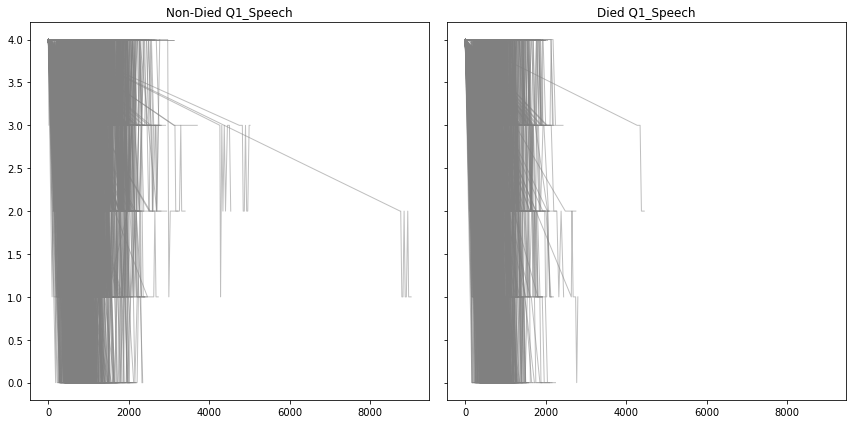

In [119]:
plot_question(scale_do, 'Q1_Speech')

## Plot linreg results for total score

In [37]:
# take a random sample of 100 points
slope_sample= linreg['slope'].sample(n=100)

In [38]:
# round the numbers for plotting
slope_sample=np.round(list(linreg['slope'].values),6)

In [39]:
plt.hist(slope_sample, bins=30, ec='black')
plt.title("Functional assessment slopes")
plt.xlabel("linear slope")
plt.show()

/Applications/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


## Individual Subject Data

In [17]:
# plot each score
Qs=['Q1_Speech', 'Q2_Salivation', 'Q3_Swallowing', 'Q4_Handwriting', 
    'Q5a_Cutting_without_Gastrostomy', 'Q5b_Cutting_with_Gastrostomy', 
    'Q6_Dressing_and_Hygiene', 'Q7_Turning_in_Bed', 'Q8_Walking', 'Q9_Climbing_Stairs', 
    'Q10_Respiratory', 'R_1_Dyspnea', 'R_2_Orthopnea', 
    'R_3_Respiratory_Insufficiency']

def plot_q_scores(df):
    if len(df)> 200:
        return "df is too long"
    plt.figure(figsize=(12,6))
    
    for feature in df[Qs]:
        if np.all(df[feature].isnull()):
            continue
        if feature == 'ALSFRS_R_Total' or feature == 'ALSFRS_Total':
            plt.plot(df['study_day'], df[feature], color='red')
        else:
            plt.plot(df['study_day'], df[feature])
    plt.title("Individual Change in Functional Assessment")
    plt.show()